Import all the required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing 
from sklearn.feature_selection import chi2
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
import math

Read the data ,analyse its shape and display the columns

In [184]:
data=pd.read_csv('train.csv')
print(data.shape)
print(data.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


Check for the null values in the dataframe

In [185]:
print(data.isnull().sum(axis=0))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Remove the NA values and store it in clean_data

In [186]:
#x=data.iloc[:,[0,2,4,5,6,7,9,10,11]]
#y=data.iloc[:,1]
clean_data=data.dropna()
#x=clean_data.iloc[:,[0,2,4,5,6,7,9,10,11]]
#y=clean_data.iloc[:,1]

In [187]:
print(data.nunique())

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


Label encoder for categorical variables and store in lb_encoder.

In [188]:
lb_encoded=clean_data.copy()
label_encoder = preprocessing.LabelEncoder() 
lb_encoded['Pclass']= label_encoder.fit_transform(lb_encoded['Pclass']) 
lb_encoded['SibSp']= label_encoder.fit_transform(lb_encoded['SibSp']) 
lb_encoded['Parch']= label_encoder.fit_transform(lb_encoded['Parch']) 
lb_encoded['Sex']= label_encoder.fit_transform(lb_encoded['Sex']) 
lb_encoded['Embarked']= label_encoder.fit_transform(lb_encoded['Embarked'])
lb_encoded.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0
3,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2
6,7,0,0,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,2
10,11,1,2,"Sandstrom, Miss. Marguerite Rut",0,4.0,1,1,PP 9549,16.7000,G6,2
11,12,1,0,"Bonnell, Miss. Elizabeth",0,58.0,0,0,113783,26.5500,C103,2


One hot encoding.

In [189]:
code_columns = ["Pclass","SibSp","Parch","Sex","Embarked"]
one_hot_enc=pd.get_dummies(clean_data,prefix_sep="__",columns=code_columns)
print("Original Data Shape:",data.shape)
print("One Hot Encoded:",one_hot_enc.shape)

Original Data Shape: (891, 12)
One Hot Encoded: (183, 23)


Store the dependent and independent columns in separate variable for two dataframe i.e clean data and label encoded.

In [190]:
x=clean_data.iloc[:,[0,2,4,5,6,7,9,11]]
y=clean_data.iloc[:,1]
x1=lb_encoded.iloc[:,[0,2,4,5,6,7,9,11]]
y1=lb_encoded.iloc[:,1]

Use co-relation heat map for data with na values and clean values

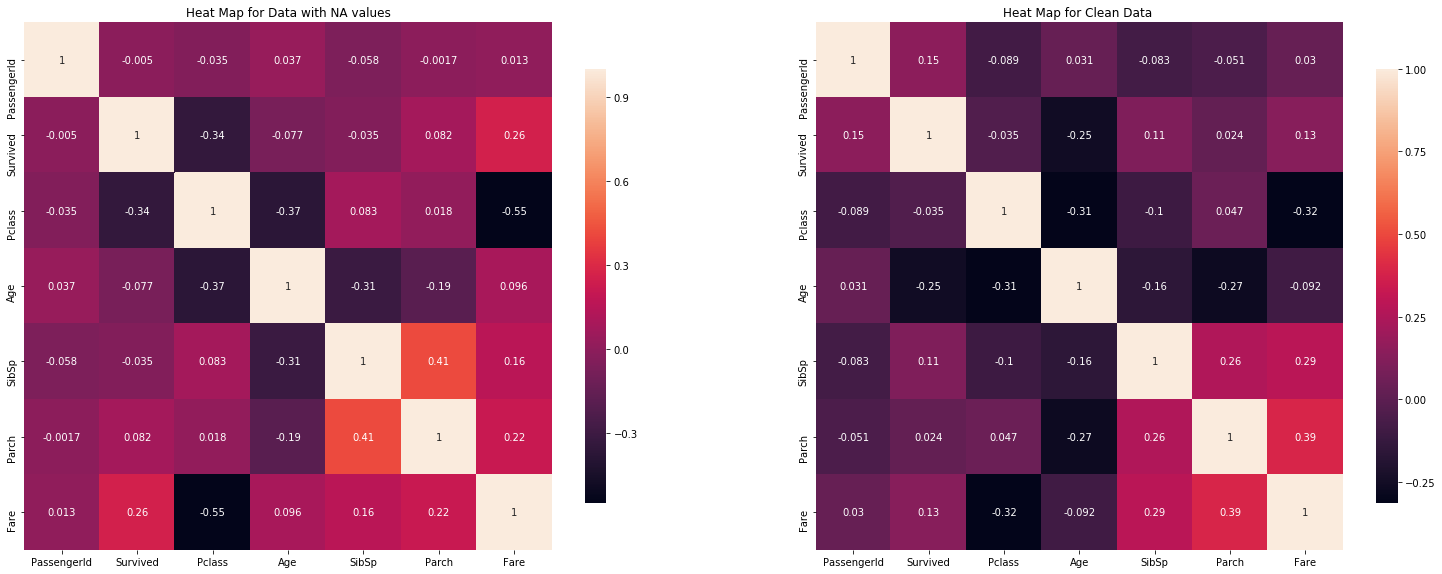

In [191]:
fig = plt.figure(figsize=(26,20))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
corr =data.corr()
sns.heatmap(corr, annot=True,square=True,ax=ax1,cbar_kws={'shrink': .4})
ax1.set_title('Heat Map for Data with NA values')
corr =clean_data.corr()
sns.heatmap(corr, annot=True,square=True,ax=ax2,cbar_kws={'shrink': .4})
ax2.set_title('Heat Map for Clean Data ')
plt.show()

From the heat map for data with NA values,survived is the dependent columns.<br>
It is clear that Pclass is negatively correlated (-0.34) and Fare is positively correlated (0.26).<br>
On the other case,if we see the heat map for clean data.<br>
Age is negatively correlated which was not seen in data with na values.<br>
In heat map of clean data it shows that passenger id is correlated 0.15 but it cannot be considered as a dependent feature.<br>
Also in clean data parch is not realted.<br>
So we can see that features change with raw data and clean data.

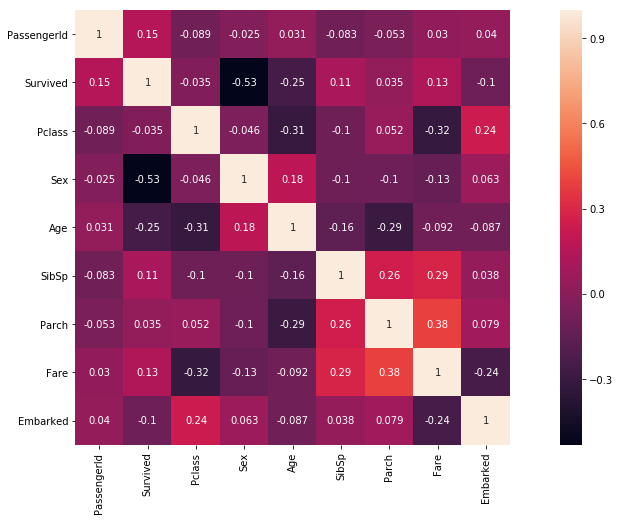

In [192]:
corr =lb_encoded.corr()
plt.figure(figsize=(18,8))
sns.heatmap(corr, annot=True,square=True)
plt.show()

From the above we understood correlated matrix for raw and clean data .<br>
Some of the features can be seen only if it is label encoded.<br>
Feature sex was not seen in data without label encoded .So now only we are able to understood sex is -0.53 correlated.<br>
Age is also -0.25 negatively correlated.

We can also use select k best to find the best features.

In [193]:
bestfeatures = SelectKBest(k=6)
fit = bestfeatures.fit(x1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x1.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score'))

         Specs      Score
2          Sex  71.605923
3          Age  12.491639
0  PassengerId   4.081191
6         Fare   3.321597
4        SibSp   2.070439
7     Embarked   1.863299
5        Parch   0.222216
1       Pclass   0.216220


We can see that sex and age has high score which is seen from corrleation heat map of label encoded data.

Create a User defined function ,which reduces size of code.It can be called any number of times without repeating the codes.<br>
Functions for metrics calculation ,random forest,decision tree,logistic regression,knn,split data,grid cv.

In [194]:
def metrics_calculations(y_test,y_pred):
    print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
    tn,fp,fn,tp=metrics.confusion_matrix(y_test, y_pred).ravel()
    print("True Negative:",tn)
    print("False Positive:",fp)
    print("False Negative:",fn)
    print("True Positive:",tp)
    print(metrics.classification_report(y_test, y_pred))
    k=metrics.roc_curve(y_test,y_pred)
    #print(k)
    plt.figure()
    lw = 2
    print("Area Under Curve is:",metrics.auc(k[0],k[1]))
    plt.plot(k[0],k[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)'%metrics.auc(k[0],k[1]))
    plt.plot([0, 1], [0, 1],color='navy',lw=lw,linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ROC')
    plt.legend(loc="lower right")
    plt.show()
def random_forest(x_train,y_train,x_test):
    ra=RandomForestClassifier(n_estimators=700,criterion='gini')
    ra.fit(x_train,y_train)
    y_pred=ra.predict(x_test)
    return y_pred
def decision_tree(x_train,y_train,x_test):
    dtc=DecisionTreeClassifier(criterion="gini")
    dtc=dtc.fit(x_train,y_train)
    y_pred = dtc.predict(x_test)
    return y_pred
def logistic_regression(x_train,y_train,x_test):
    model_log=LogisticRegression()
    model_log.fit(x_train,y_train)
    y_pred=model_log.predict(x_test)
    return y_pred
def knn(x_train,y_train,x_test):
    kvalue=list(clean_data.shape)
    kv=int(math.sqrt(kvalue[0]))
    knn = KNeighborsClassifier(n_neighbors=kv)
    knn.fit(x_train,y_train)
    y_pred=knn.predict(x_test)
    return y_pred
def gridcv(model,parameters,x_train,y_train):
    grid_search = GridSearchCV(estimator = model, param_grid = parameters,scoring ='roc_auc',n_jobs = -1)
    grid_search = grid_search.fit(x_train,y_train)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print("")
    print()
def split_train(x1,y1,size):
    x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=size,random_state=0)
    return [x_train,x_test,y_train,y_test]
    

Use loop to split data into different split ratio for train and test data.<br>
Apply all models calculate metrics like accuracy and plot ROC curve.

***********************************************Random Forest- 0.4 ***********************************************
Accuracy: 0.824324324324
True Negative: 12
False Positive: 9
False Negative: 4
True Positive: 49
             precision    recall  f1-score   support

          0       0.75      0.57      0.65        21
          1       0.84      0.92      0.88        53

avg / total       0.82      0.82      0.82        74

Area Under Curve is: 0.747978436658


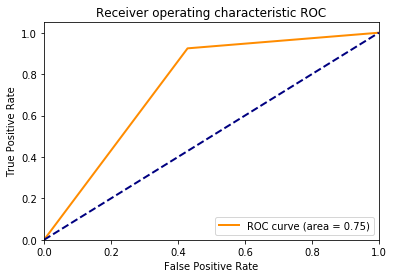

***********************************************Decision Tree: 0.4 ***********************************************
Accuracy: 0.702702702703
True Negative: 11
False Positive: 10
False Negative: 12
True Positive: 41
             precision    recall  f1-score   support

          0       0.48      0.52      0.50        21
          1       0.80      0.77      0.79        53

avg / total       0.71      0.70      0.71        74

Area Under Curve is: 0.648697214735


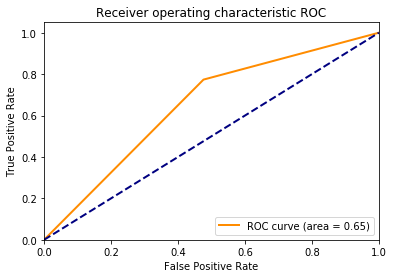

***********************************************Logistic Regression 0.4 ***********************************************
Accuracy: 0.797297297297
True Negative: 12
False Positive: 9
False Negative: 6
True Positive: 47
             precision    recall  f1-score   support

          0       0.67      0.57      0.62        21
          1       0.84      0.89      0.86        53

avg / total       0.79      0.80      0.79        74

Area Under Curve is: 0.729110512129


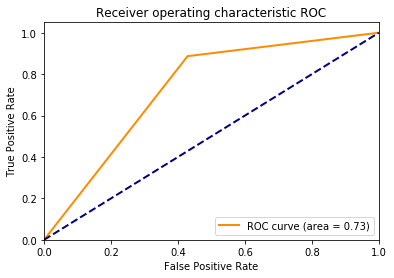

***********************************************KNN 0.4 ***********************************************
Accuracy: 0.716216216216
True Negative: 6
False Positive: 15
False Negative: 6
True Positive: 47
             precision    recall  f1-score   support

          0       0.50      0.29      0.36        21
          1       0.76      0.89      0.82        53

avg / total       0.68      0.72      0.69        74

Area Under Curve is: 0.586253369272


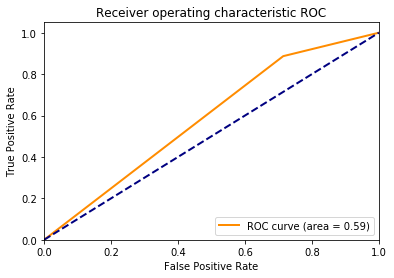



***********************************************Random Forest- 0.3 ***********************************************
Accuracy: 0.836363636364
True Negative: 6
False Positive: 7
False Negative: 2
True Positive: 40
             precision    recall  f1-score   support

          0       0.75      0.46      0.57        13
          1       0.85      0.95      0.90        42

avg / total       0.83      0.84      0.82        55

Area Under Curve is: 0.70695970696


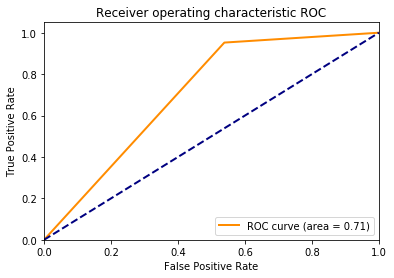

***********************************************Decision Tree: 0.3 ***********************************************
Accuracy: 0.672727272727
True Negative: 6
False Positive: 7
False Negative: 11
True Positive: 31
             precision    recall  f1-score   support

          0       0.35      0.46      0.40        13
          1       0.82      0.74      0.78        42

avg / total       0.71      0.67      0.69        55

Area Under Curve is: 0.599816849817


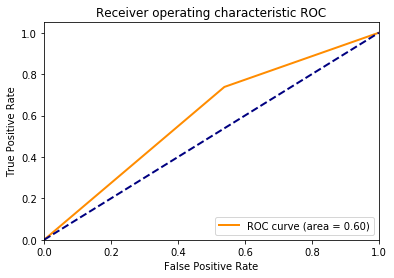

***********************************************Logistic Regression 0.3 ***********************************************
Accuracy: 0.818181818182
True Negative: 9
False Positive: 4
False Negative: 6
True Positive: 36
             precision    recall  f1-score   support

          0       0.60      0.69      0.64        13
          1       0.90      0.86      0.88        42

avg / total       0.83      0.82      0.82        55

Area Under Curve is: 0.774725274725


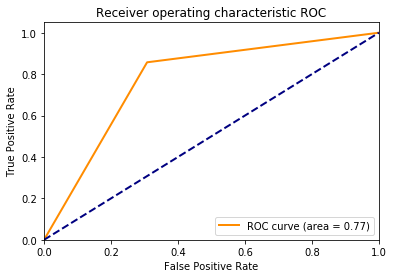

***********************************************KNN 0.3 ***********************************************
Accuracy: 0.709090909091
True Negative: 3
False Positive: 10
False Negative: 6
True Positive: 36
             precision    recall  f1-score   support

          0       0.33      0.23      0.27        13
          1       0.78      0.86      0.82        42

avg / total       0.68      0.71      0.69        55

Area Under Curve is: 0.543956043956


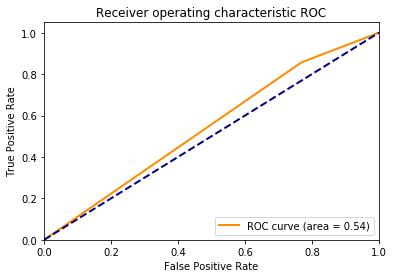



***********************************************Random Forest- 0.25 ***********************************************
Accuracy: 0.891304347826
True Negative: 5
False Positive: 4
False Negative: 1
True Positive: 36
             precision    recall  f1-score   support

          0       0.83      0.56      0.67         9
          1       0.90      0.97      0.94        37

avg / total       0.89      0.89      0.88        46

Area Under Curve is: 0.764264264264


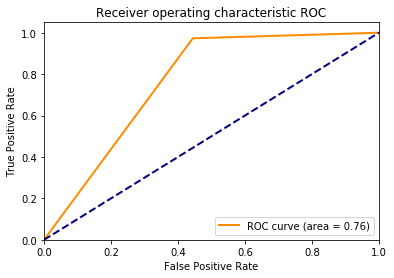

***********************************************Decision Tree: 0.25 ***********************************************
Accuracy: 0.760869565217
True Negative: 4
False Positive: 5
False Negative: 6
True Positive: 31
             precision    recall  f1-score   support

          0       0.40      0.44      0.42         9
          1       0.86      0.84      0.85        37

avg / total       0.77      0.76      0.77        46

Area Under Curve is: 0.641141141141


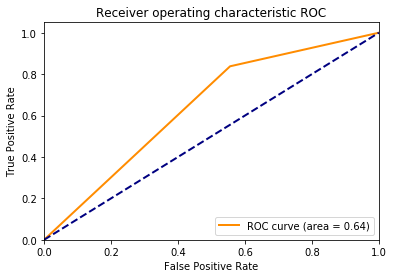

***********************************************Logistic Regression 0.25 ***********************************************
Accuracy: 0.826086956522
True Negative: 7
False Positive: 2
False Negative: 6
True Positive: 31
             precision    recall  f1-score   support

          0       0.54      0.78      0.64         9
          1       0.94      0.84      0.89        37

avg / total       0.86      0.83      0.84        46

Area Under Curve is: 0.807807807808


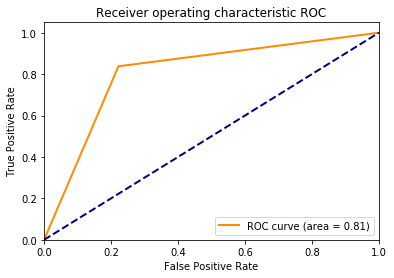

***********************************************KNN 0.25 ***********************************************
Accuracy: 0.782608695652
True Negative: 3
False Positive: 6
False Negative: 4
True Positive: 33
             precision    recall  f1-score   support

          0       0.43      0.33      0.38         9
          1       0.85      0.89      0.87        37

avg / total       0.76      0.78      0.77        46

Area Under Curve is: 0.612612612613


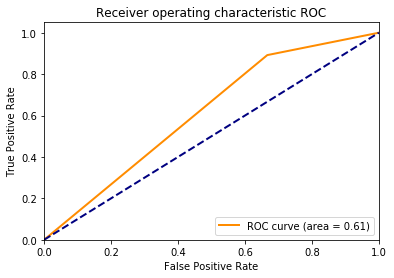



***********************************************Random Forest- 0.2 ***********************************************
Accuracy: 0.864864864865
True Negative: 3
False Positive: 4
False Negative: 1
True Positive: 29
             precision    recall  f1-score   support

          0       0.75      0.43      0.55         7
          1       0.88      0.97      0.92        30

avg / total       0.85      0.86      0.85        37

Area Under Curve is: 0.697619047619


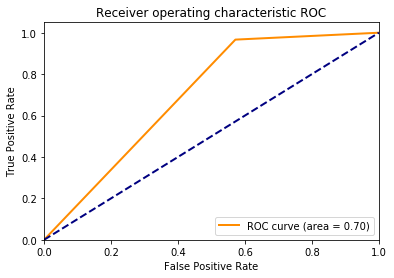

***********************************************Decision Tree: 0.2 ***********************************************
Accuracy: 0.756756756757
True Negative: 3
False Positive: 4
False Negative: 5
True Positive: 25
             precision    recall  f1-score   support

          0       0.38      0.43      0.40         7
          1       0.86      0.83      0.85        30

avg / total       0.77      0.76      0.76        37

Area Under Curve is: 0.630952380952


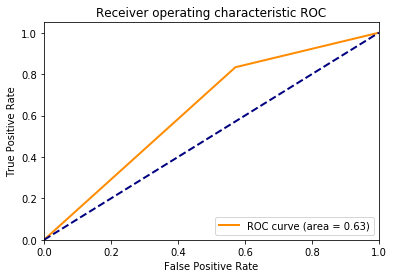

***********************************************Logistic Regression 0.2 ***********************************************
Accuracy: 0.891891891892
True Negative: 5
False Positive: 2
False Negative: 2
True Positive: 28
             precision    recall  f1-score   support

          0       0.71      0.71      0.71         7
          1       0.93      0.93      0.93        30

avg / total       0.89      0.89      0.89        37

Area Under Curve is: 0.82380952381


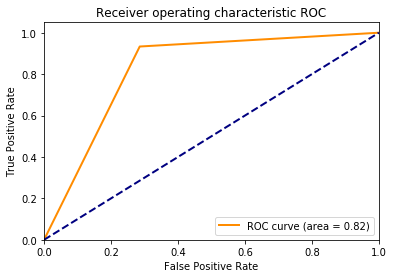

***********************************************KNN 0.2 ***********************************************
Accuracy: 0.756756756757
True Negative: 2
False Positive: 5
False Negative: 4
True Positive: 26
             precision    recall  f1-score   support

          0       0.33      0.29      0.31         7
          1       0.84      0.87      0.85        30

avg / total       0.74      0.76      0.75        37

Area Under Curve is: 0.57619047619


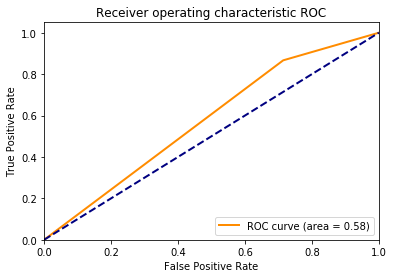



***********************************************Random Forest- 0.1 ***********************************************
Accuracy: 0.789473684211
True Negative: 2
False Positive: 2
False Negative: 2
True Positive: 13
             precision    recall  f1-score   support

          0       0.50      0.50      0.50         4
          1       0.87      0.87      0.87        15

avg / total       0.79      0.79      0.79        19

Area Under Curve is: 0.683333333333


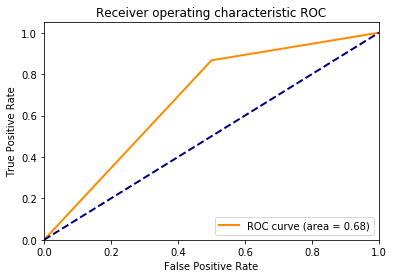

***********************************************Decision Tree: 0.1 ***********************************************
Accuracy: 0.736842105263
True Negative: 2
False Positive: 2
False Negative: 3
True Positive: 12
             precision    recall  f1-score   support

          0       0.40      0.50      0.44         4
          1       0.86      0.80      0.83        15

avg / total       0.76      0.74      0.75        19

Area Under Curve is: 0.65


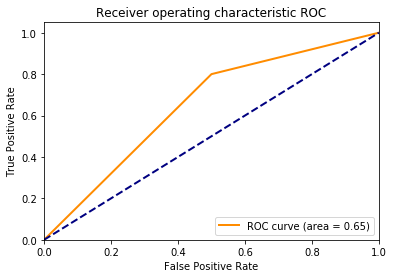

***********************************************Logistic Regression 0.1 ***********************************************
Accuracy: 0.842105263158
True Negative: 2
False Positive: 2
False Negative: 1
True Positive: 14
             precision    recall  f1-score   support

          0       0.67      0.50      0.57         4
          1       0.88      0.93      0.90        15

avg / total       0.83      0.84      0.83        19

Area Under Curve is: 0.716666666667


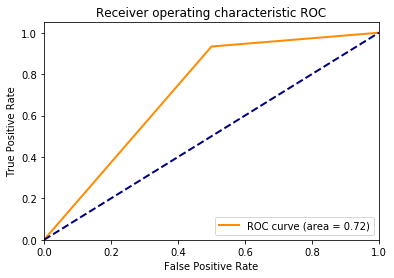

***********************************************KNN 0.1 ***********************************************
Accuracy: 0.842105263158
True Negative: 2
False Positive: 2
False Negative: 1
True Positive: 14
             precision    recall  f1-score   support

          0       0.67      0.50      0.57         4
          1       0.88      0.93      0.90        15

avg / total       0.83      0.84      0.83        19

Area Under Curve is: 0.716666666667


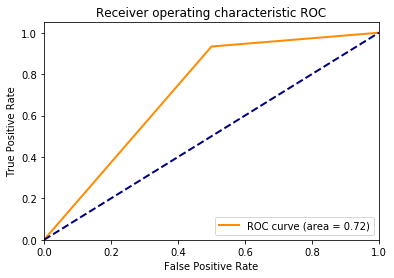

In [195]:
#x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=0.25,random_state=0)
size=[0.4,0.3,0.25,0.2,0.1]
for i in range (5):
    result=split_train_test(x1,y1,size[i])
    x_train=result[0]
    x_test=result[1]
    y_train=result[2]
    y_test=result[3]
    rf_pred=random_forest(x_train,y_train,x_test)
    dt_pred=decision_tree(x_train,y_train,x_test)
    lr_pred=logistic_regression(x_train,y_train,x_test)
    kn_pred=knn(x_train,y_train,x_test)
    print("***********************************************Random Forest-",size[i],"***********************************************")
    metrics_calculations(y_test,rf_pred)
    print("***********************************************Decision Tree:",size[i],"***********************************************")
    metrics_calculations(y_test,dt_pred)
    print("***********************************************Logistic Regression",size[i],"***********************************************")
    metrics_calculations(y_test,lr_pred)
    print("***********************************************KNN",size[i],"***********************************************")
    metrics_calculations(y_test,kn_pred)
    print()
    print()

 From all the above results ,it was seen that data with 80:20 ratio and logistic regression gave the best accuracy with 89.18% of accuracy.<br>
Area under ROC curve was 0.82.<br>
Precision and Recall was 89%.

Use grid search cv to find the best parameter to fit the model.<br>

In [196]:
print("*****************************************Grid CV for Random Forest**************************************************")
model=RandomForestClassifier()
parameters = {
    "n_estimators": [100,200,300,400,500,600],
    "criterion" : ["gini","entropy"]
}
gridcv(model,parameters,x_train,y_train)
print("*****************************************Grid CV for Decision Tree***************************************************")
model=DecisionTreeClassifier()
parameters = {
    "splitter" : ['random','best'],
    "criterion" : ["gini","entropy"]
}
gridcv(model,parameters,x_train,y_train)
print("**************************************Grid CV for K Nearest Neighbour***********************************************")
model=KNeighborsClassifier()
parameters = {
    "n_neighbors": [10,20,30,40,50,60]
}
gridcv(model,parameters,x_train,y_train)
print("**************************************Grid CV for Logistic Regression***********************************************")
model=LogisticRegression()
parameters = {
    "penalty" :['l1','l2'],
    "max_iter" : [100,220,130,140,150,160]
}
gridcv(model,parameters,x_train,y_train)

*****************************************Grid CV for Random Forest**************************************************
0.827815218942
{'criterion': 'gini', 'n_estimators': 200}


*****************************************Grid CV for Decision Tree***************************************************
0.690860790187
{'criterion': 'entropy', 'splitter': 'random'}


**************************************Grid CV for K Nearest Neighbour***********************************************
0.554401119669
{'n_neighbors': 20}


**************************************Grid CV for Logistic Regression***********************************************
0.823286621024
{'max_iter': 100, 'penalty': 'l2'}




Since we had decided ,logistic regression with 80:20 split ration gave the best accuracy .<br>
We can finalize the model of logistic regression with max iter=100 and penalty type=L2

Accuracy: 0.891891891892
True Negative: 5
False Positive: 2
False Negative: 2
True Positive: 28
             precision    recall  f1-score   support

          0       0.71      0.71      0.71         7
          1       0.93      0.93      0.93        30

avg / total       0.89      0.89      0.89        37

Area Under Curve is: 0.82380952381


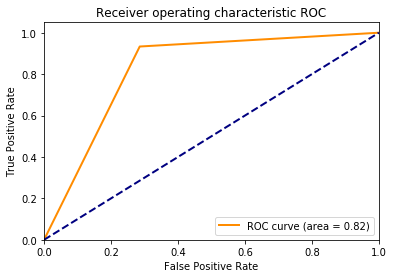

In [197]:
result=split_train_test(x1,y1,0.2)
x_train=result[0]
x_test=result[1]
y_train=result[2]
y_test=result[3]
model_log=LogisticRegression(max_iter=100,penalty='l2')
model_log.fit(x_train,y_train)
y_pred=model_log.predict(x_test)
metrics_calculations(y_test,y_pred)

From the above metrics ,we decide this as the model.<br>
Also there are more other parameters which can used to find out the best parameters.<br>
It can be further improved by performing Exploratory Data Analysis like univariate ,multivariate and replacing na data with imputation techniques to imporve the data based on which model metrica can be improved.<br>